In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Building an Image Classifier

*Here we will train a digits classifiers on MNIST dataset*

In [ ]:
import tensorflow as tf
from tensorflow import keras

Let's load the dataset:

Go to the InClass Kaggle competition https://www.kaggle.com/t/d49c78cbdebb4bc18a53ea5360ae055f \
register and download training and test dataset. Train model on the training dataset. Try to improve baseline results.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np

In [ ]:
### download the csv files first, and put them in the same folder, as the notebook

train_data = np.genfromtxt('/content/drive/My Drive/wbi/train_data.csv', delimiter=',')
test_data = np.genfromtxt('/content/drive/My Drive/wbi/test_data.csv', delimiter=',')

In [ ]:
### last column is the target value

X_train_full = train_data[:,:-1]
y_train_full = train_data[:,-1]

In [ ]:
X_test = test_data

Let's transform rows to images

In [ ]:
X_train_full = X_train_full.reshape(-1, 28, 28,1)
X_test = X_test.reshape(-1, 28, 28,1)

As an example, here you have a simple neural network. Try different options (build your own CNN), and submit solution to Kaggle competition.

In [ ]:
X_train_full.shape

(12000, 28, 28, 1)

In [ ]:
X_valid, X_train = X_train_full[:2000] / 255., X_train_full[2000:] / 255.
y_valid, y_train = y_train_full[:2000], y_train_full[2000:]
X_test = X_test / 255.

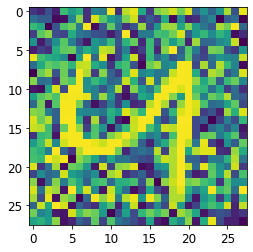

In [ ]:
plt.imshow(X_train[2][:,:,0])

In [156]:
datagen_train = keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=5,
    width_shift_range=2,
    height_shift_range=2,
    horizontal_flip=False)
dataget_test = keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
)
datagen_train.fit(X_train)
dataget_test.fit(X_train)

In [157]:
model_cnn = keras.models.Sequential([
    keras.layers.Conv2D(128, (3,3),padding="same", input_shape=[28, 28, 1]),
    keras.layers.Conv2D(128, (3,3), padding="same"),
    keras.layers.Conv2D(128, (3,3), padding="same"),
    keras.layers.Conv2D(128, (3,3), padding="same"),
    keras.layers.Conv2D(128, (3,3), padding="same"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), padding="same"),
    keras.layers.Conv2D(128, (3,3), padding="same"),
    keras.layers.MaxPooling2D((2,2)),    
    keras.layers.Conv2D(128, (3,3), padding="same"),
    keras.layers.Conv2D(128, (3,3), padding="same"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), padding="same"),
    keras.layers.Conv2D(128, (3,3), padding="same"),
    keras.layers.MaxPooling2D((2,2)),    
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="sigmoid")
])

In [158]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15,
                                                  restore_best_weights=True,
                                                 monitor="val_accuracy",
                                                 verbose=1)
reduce_lr_plateau = keras.callbacks.ReduceLROnPlateau(patience=6,monitor="val_accuracy",
                                                     verbose=1,
                                                     factor=0.5,
                                                      min_lr=0.000041
                                                     )
callbacks = [early_stopping_cb, reduce_lr_plateau]

In [160]:
model_cnn.compile(loss="sparse_categorical_crossentropy",
              optimizer= keras.optimizers.Adamax(), ##keras.optimizers.SGD(0.001),
              metrics=["accuracy"])

In [161]:
history = model_cnn.fit(datagen_train.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) / 32, epochs=200,
             validation_data=dataget_test.flow(X_valid, y_valid, batch_size=32),
                       callbacks=callbacks)

Epoch 1/200
313/312 [==============================] - 7s 21ms/step - loss: 2.3037 - accuracy: 0.1090 - val_loss: 2.3016 - val_accuracy: 0.1125
Epoch 2/200
313/312 [==============================] - 6s 21ms/step - loss: 2.3031 - accuracy: 0.1039 - val_loss: 2.3020 - val_accuracy: 0.1130
Epoch 3/200
313/312 [==============================] - 7s 21ms/step - loss: 2.3033 - accuracy: 0.1055 - val_loss: 2.3020 - val_accuracy: 0.1130
Epoch 4/200
313/312 [==============================] - 7s 21ms/step - loss: 2.3027 - accuracy: 0.1046 - val_loss: 2.3021 - val_accuracy: 0.1130
Epoch 5/200
313/312 [==============================] - 7s 21ms/step - loss: 2.3032 - accuracy: 0.1045 - val_loss: 2.3010 - val_accuracy: 0.1130
Epoch 6/200
313/312 [==============================] - 7s 21ms/step - loss: 2.3028 - accuracy: 0.1072 - val_loss: 2.3020 - val_accuracy: 0.1130
Epoch 7/200
313/312 [==============================] - 7s 21ms/step - loss: 2.3032 - accuracy: 0.1055 - val_loss: 2.3010 - val_accuracy:

Now that we trained the model, we need to make a prediction on a test set, and save into csv

In [150]:
predictions = model_cnn.predict(X_test)

In [151]:
predictions_class = np.argmax(predictions, axis=1)

In [152]:
predictions_class

array([6, 6, 8, ..., 6, 0, 3])

In [153]:
df_submission = pd.DataFrame(predictions_class, columns = ["Category"])
df_submission["Id"] = df_submission.index
df_submission = df_submission[["Id", "Category"]]

In [154]:
df_submission.head()

,Id,Category
0,0,6
1,1,6
2,2,8
3,3,4
4,4,5


In [155]:
df_submission.to_csv("baseline2.csv", index=False)